Open Play Shots - Expected Behind Model - Model Evaluation - GBM

In [1]:
import pandas as pd
import numpy as np
import joblib
import warnings
warnings.filterwarnings('ignore')

from expected_score_model.config import behind_open_shots_file_path
from expected_score_model.domain.contracts.modelling_data_contract import ModellingDataContract
from expected_score_model.domain.modelling.supermodel import SuperXGBClassifier
from expected_score_model.domain.modelling.model_evaluation import XGBClassifierEvaluator

pd.options.display.max_rows = 999
pd.options.display.max_columns = 999

%load_ext autoreload
%autoreload 2

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


New Model

In [2]:
new_version = 8
model_name = "expected_behind_open"
model_file_path = "/Users/ciaran/Documents/Projects/AFL/git-repositories/expected-score-model/model_outputs/models"
preproc_file_path = "/Users/ciaran/Documents/Projects/AFL/git-repositories/expected-score-model/model_outputs/preprocessors"

Comparison Model

In [3]:
old_version = new_version - 1
compare_train_predictions_file_path = "/Users/ciaran/Documents/Projects/AFL/git-repositories/expected-score-model/model_outputs/predictions/train_predictions_"+model_name+"_v"+str(old_version)+".csv"
compare_test_predictions_file_path = "/Users/ciaran/Documents/Projects/AFL/git-repositories/expected-score-model/model_outputs/predictions/test_predictions_"+model_name+"_v"+str(old_version)+".csv"

Response

In [4]:
RESPONSE = ModellingDataContract.RESPONSE_BEHIND

Features

In [5]:
FEATURES = ModellingDataContract.feature_list_open_behind

Load Data

In [6]:
df_modelling = pd.read_csv(behind_open_shots_file_path)
df_modelling.tail()

,Chain_Number,Initial_State,Final_State,Order,Quarter,Quarter_Duration_Chain_Start,Quarter_Duration,Team_Chain,Team,Player,AFL_API_Player_ID,Description,x,y,Disposal,Shot_At_Goal,Behind_Detail,Venue_Width,Venue_Length,Home_Team,Away_Team,Home_Team_Direction_Q1,Match_ID,Round_ID,Year,Season,Goal,Behind,Miss,Score,Event_Type1,Set_Shot,x0,y0,Distance_Since_Last_Action,Distance_to_Middle_Goal,Angle_to_Middle_Goal,Visible_Goal_Angle,BehindTrainingSet,BehindTestSet,BehindValidationSet
14170,166,ballUp,behind,1260.0,3,1299,1303.0,Collingwood,Collingwood,Mason Cox,Mason_Cox,Kick,73.0,-9.0,ineffective,True,NaN,141,160,Collingwood,Brisbane Lions,right,2023F4_Collingwood_BrisbaneLions,2023F4,NaN,2023.0,0,1,0,1,Handball Received,False,73.0,-9.0,0.000000,11.401754,0.909753,0.374081,False,False,True
14171,184,possGain,behind,1430.0,4,122,156.0,Collingwood,Collingwood,Nick Daicos,Nick_Daicos,Kick,72.0,24.0,ineffective,True,NaN,141,160,Collingwood,Brisbane Lions,right,2023F4_Collingwood_BrisbaneLions,2023F4,NaN,2023.0,0,1,0,1,Gather,False,72.0,24.0,2.000000,25.298221,1.249046,0.081301,True,False,False
14172,207,possGain,behind,1587.0,4,744,746.0,Brisbane Lions,Brisbane Lions,Keidean Coleman,Keidean_Coleman,Kick,26.0,-1.0,ineffective,True,NaN,141,160,Collingwood,Brisbane Lions,right,2023F4_Collingwood_BrisbaneLions,2023F4,NaN,2023.0,0,1,0,1,Handball Received,False,26.0,-1.0,7.071068,54.009258,0.018516,0.118895,True,False,False
14173,221,ballUp,goal,1718.0,4,1109,1128.0,Brisbane Lions,Brisbane Lions,Charlie Cameron,Charlie_Cameron,Kick,73.0,6.0,effective,True,NaN,141,160,Collingwood,Brisbane Lions,right,2023F4_Collingwood_BrisbaneLions,2023F4,NaN,2023.0,1,0,0,6,Hard Ball Get,False,73.0,6.0,2.000000,9.219544,0.708626,0.599251,True,False,False
14174,222,centreBounce,goal,1732.0,4,1202,1219.0,Collingwood,Collingwood,Jordan De Goey,Jordan_De_Goey,Kick,32.0,8.0,effective,True,NaN,141,160,Collingwood,Brisbane Lions,right,2023F4_Collingwood_BrisbaneLions,2023F4,NaN,2023.0,1,0,0,6,Handball Received,False,32.0,8.0,7.211103,48.662100,0.165149,0.130293,True,False,False


In [7]:
df_modelling[['ballUp', 'centreBounce', 'kickIn', 'possGain', 'throwIn']] = pd.get_dummies(df_modelling['Initial_State'])

In [8]:
training_data = df_modelling[df_modelling[RESPONSE+"TrainingSet"]]
test_data = df_modelling[df_modelling[RESPONSE+"TestSet"]]
cal_data = df_modelling[df_modelling[RESPONSE+"ValidationSet"]]

In [9]:
X_train, y_train = training_data.drop(columns=[RESPONSE]), training_data[RESPONSE]
X_test, y_test = test_data.drop(columns=[RESPONSE]), test_data[RESPONSE]
X_cal, y_cal = cal_data.drop(columns=[RESPONSE]), cal_data[RESPONSE]

In [10]:
X_test.head()

,Chain_Number,Initial_State,Final_State,Order,Quarter,Quarter_Duration_Chain_Start,Quarter_Duration,Team_Chain,Team,Player,AFL_API_Player_ID,Description,x,y,Disposal,Shot_At_Goal,Behind_Detail,Venue_Width,Venue_Length,Home_Team,Away_Team,Home_Team_Direction_Q1,Match_ID,Round_ID,Year,Season,Goal,Miss,Score,Event_Type1,Set_Shot,x0,y0,Distance_Since_Last_Action,Distance_to_Middle_Goal,Angle_to_Middle_Goal,Visible_Goal_Angle,BehindTrainingSet,BehindTestSet,BehindValidationSet,ballUp,centreBounce,kickIn,possGain,throwIn
1,6,possGain,goal,61.0,1,149,168.0,Brisbane Lions,Brisbane Lions,Zac Bailey,Zac_Bailey,Kick,35.0,19.0,effective,True,NaN,138,156,Brisbane Lions,Sydney,right,202101_BrisbaneLions_Sydney,202101,2021.0,NaN,1,0,6,Handball Received,False,35.0,19.0,7.000000,47.010637,0.416065,0.125105,False,True,False,False,False,False,True,False
5,43,possGain,behind,444.0,1,1272,1317.0,Brisbane Lions,Brisbane Lions,Joe Daniher,Joe_Daniher,Kick,27.0,31.0,ineffective,True,NaN,138,156,Brisbane Lions,Sydney,right,202101_BrisbaneLions_Sydney,202101,2021.0,NaN,0,0,1,Handball Received,False,27.0,31.0,3.162278,59.682493,0.546167,0.091898,False,True,False,False,False,False,True,False
9,83,throwIn,goal,781.0,2,848,861.0,Brisbane Lions,Brisbane Lions,Jarryd Lyons,Jarryd_Lyons,Kick,46.0,2.0,effective,True,NaN,138,156,Brisbane Lions,Sydney,right,202101_BrisbaneLions_Sydney,202101,2021.0,NaN,1,0,6,Gather,False,46.0,2.0,5.000000,32.062439,0.062419,0.201226,False,True,False,False,False,False,False,True
11,91,possGain,miss,863.0,2,1223,1226.0,Brisbane Lions,Brisbane Lions,Zac Bailey,Zac_Bailey,Kick,54.0,-39.0,clanger,True,NaN,138,156,Brisbane Lions,Sydney,right,202101_BrisbaneLions_Sydney,202101,2021.0,NaN,0,1,0,Hard Ball Get Crumb,False,54.0,-39.0,7.810250,45.793013,1.019141,0.073607,False,True,False,False,False,False,True,False
19,161,possGain,goal,1422.0,3,1570,1575.0,Brisbane Lions,Brisbane Lions,Jarrod Berry,Jarrod_Berry,Kick,38.0,-37.0,effective,True,NaN,138,156,Brisbane Lions,Sydney,right,202101_BrisbaneLions_Sydney,202101,2021.0,NaN,1,0,6,Handball Received,False,38.0,-37.0,9.219544,54.488531,0.746457,0.086523,False,True,False,False,False,False,True,False


Preprocess Data

In [11]:
# preprocessor = DataPreprocessor()
# preprocessor.fit(X_train)

# X_train_preproc = preprocessor.transform(X_train)
# X_test_preproc = preprocessor.transform(X_test)

In [12]:
X_train_preproc = X_train[FEATURES]
X_test_preproc = X_test[FEATURES]

In [13]:
X_train_preproc.shape, X_test_preproc.shape

((9072, 6), (2835, 6))

In [14]:
X_train_preproc.head()

,x0,y0,Distance_Since_Last_Action,Distance_to_Middle_Goal,Angle_to_Middle_Goal,Visible_Goal_Angle
0,26.0,-21.0,8.246211,56.080300,0.383818,0.106164
2,50.0,24.0,4.000000,36.878178,0.708626,0.132764
3,34.0,15.0,15.132746,46.486557,0.328553,0.130930
4,40.0,-11.0,4.123106,39.560081,0.281772,0.156423
6,56.0,6.0,15.132746,22.803509,0.266252,0.276208


In [15]:
X_test_preproc.head()

,x0,y0,Distance_Since_Last_Action,Distance_to_Middle_Goal,Angle_to_Middle_Goal,Visible_Goal_Angle
1,35.0,19.0,7.000000,47.010637,0.416065,0.125105
5,27.0,31.0,3.162278,59.682493,0.546167,0.091898
9,46.0,2.0,5.000000,32.062439,0.062419,0.201226
11,54.0,-39.0,7.810250,45.793013,1.019141,0.073607
19,38.0,-37.0,9.219544,54.488531,0.746457,0.086523


Load Model

In [16]:
super_xgb = joblib.load(model_file_path + "/" + model_name + "_v" + str(new_version) + ".joblib")

In [17]:
super_xgb.xgb_model

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.5273798296674098, early_stopping_rounds=50,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=5.435591858736352, gpu_id=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.483684...
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=17, max_leaves=None,
              min_child_weight=85, missing=nan,
              monotone_constraints={'Angle_to_Middle_Goal': 1,
                                    'Distance_Since_Last_Action': -1,
                                    'Distance_to_Middle_Goal': 1,
                                    'Visible_Goal_Angle': -1, 'x0': 1},
              n_estimators=1000, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

Get Predictions

In [18]:
train_preds = super_xgb.predict(X_train_preproc)
test_preds = super_xgb.predict(X_test_preproc)

In [19]:
train_probas = super_xgb.predict_proba(X_train_preproc)[:, 1]
test_probas = super_xgb.predict_proba(X_test_preproc)[:, 1]

In [20]:
train_cal_probas = super_xgb.predict_proba(X_train_preproc, calibrate=True)
test_cal_probas = super_xgb.predict_proba(X_test_preproc, calibrate=True)

Compare Model

In [21]:
# compare_train_data = pd.read_csv(compare_train_predictions_file_path)
# compare_test_data = pd.read_csv(compare_test_predictions_file_path)

In [61]:
# compare_train_data = compare_train_data.rename(columns = {'xgb_preds':'old_preds',
#                                                           'xgb_probas':'old_probas',
#                                                           'xgb_probas_cal':'old_cal_probas'})
# compare_test_data = compare_test_data.rename(columns = {'xgb_preds':'old_preds',
#                                                         'xgb_probas':'old_probas',
#                                                         'xgb_probas_cal':'old_cal_probas'})

In [62]:
# training_data.shape, compare_train_data.shape

((5897, 79), (5897, 13))

In [63]:
# training_data = pd.merge(training_data, compare_train_data[["Match_ID", "Chain_Number", "Order", 'old_preds', 'old_probas', 'old_cal_probas']], how = "left", on = ["Match_ID", "Chain_Number", "Order"])
# test_data = pd.merge(test_data, compare_test_data[["Match_ID", "Chain_Number", 'Order', 'old_preds', 'old_probas', 'old_cal_probas']], how = "left", on = ["Match_ID", "Chain_Number", "Order"])

Evaluate Model

In [22]:
training_data['xgb_preds'] = train_preds
training_data['xgb_probas'] = train_probas
training_data['xgb_cal_probas'] = train_cal_probas

train_xgb_evals = XGBClassifierEvaluator(model = super_xgb.xgb_model,
                                       data = training_data,
                                       actual_name = RESPONSE,
                                       expected_name = "xgb_cal_probas",
                                       expected_label_name = "xgb_preds",
                                    #    compare_name='old_cal_probas',
                                    #    compare_label_name="old_preds"
                                       )

In [23]:
test_data['xgb_preds'] = test_preds
test_data['xgb_probas'] = test_probas
test_data['xgb_cal_probas'] = test_cal_probas

test_xgb_evals = XGBClassifierEvaluator(model = super_xgb.xgb_model,
                                       data = test_data,
                                       actual_name = RESPONSE,
                                       expected_name = "xgb_cal_probas",
                                       expected_label_name = "xgb_preds",
                                    #    compare_name = "old_cal_probas",
                                    #    compare_label_name="old_preds"
                                       )

Model Averages

In [24]:
training_data[[RESPONSE, 'xgb_probas', 'xgb_cal_probas']].describe()

,Behind,xgb_probas,xgb_cal_probas
count,9072.000000,9072.000000,9072.000000
mean,0.364087,0.362226,0.365946
std,0.481200,0.089799,0.076835
min,0.000000,0.100730,0.117370
25%,0.000000,0.323109,0.341625
50%,0.000000,0.395517,0.396550
75%,1.000000,0.419271,0.412963
max,1.000000,0.540996,0.486508


In [25]:
test_data[[RESPONSE, 'xgb_probas', 'xgb_cal_probas']].describe()

,Behind,xgb_probas,xgb_cal_probas
count,2835.000000,2835.000000,2835.000000
mean,0.357672,0.365225,0.368721
std,0.479399,0.086248,0.073380
min,0.000000,0.100730,0.117370
25%,0.000000,0.326445,0.344329
50%,0.000000,0.395517,0.396550
75%,1.000000,0.419271,0.412963
max,1.000000,0.517937,0.473808


Plots

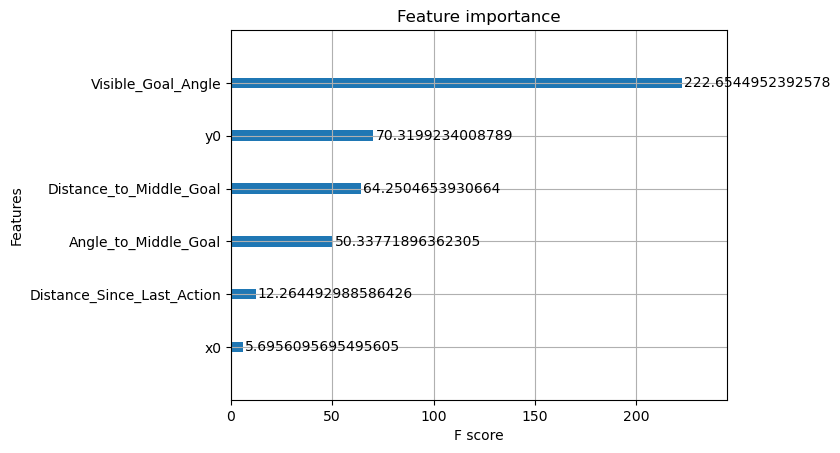

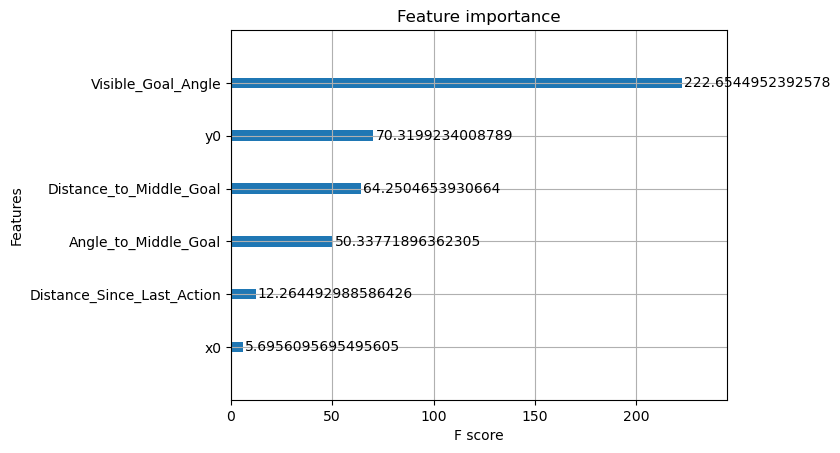

In [26]:
train_xgb_evals.plot_feature_importance(max_num_features=10, importance_type="total_gain")
test_xgb_evals.plot_feature_importance(max_num_features=10, importance_type="total_gain")

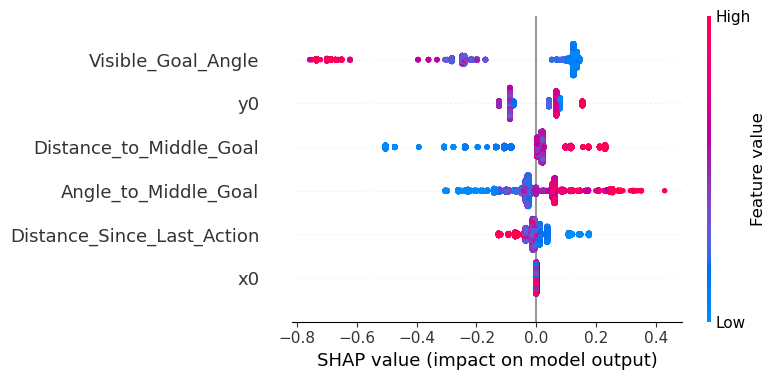

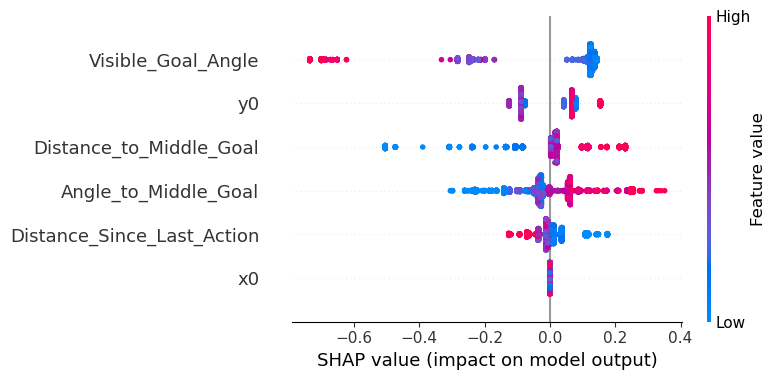

In [27]:
train_xgb_evals.plot_shap_summary_plot()
test_xgb_evals.plot_shap_summary_plot()

In [28]:
top_features = test_xgb_evals.get_ranked_feature_importance()
top_10_features = top_features[:10]
top_10_features

['Visible_Goal_Angle',
 'y0',
 'Distance_to_Middle_Goal',
 'Angle_to_Middle_Goal',
 'Distance_Since_Last_Action',
 'x0']

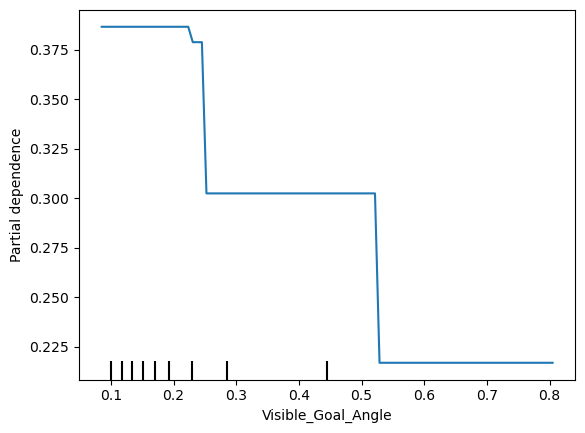

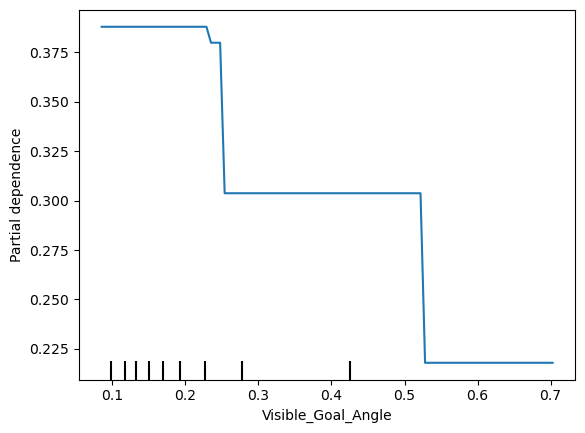

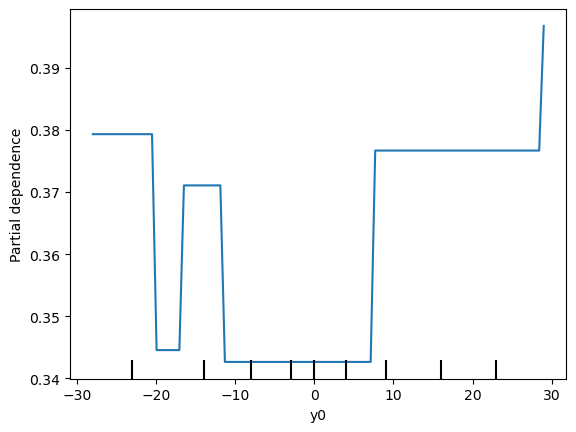

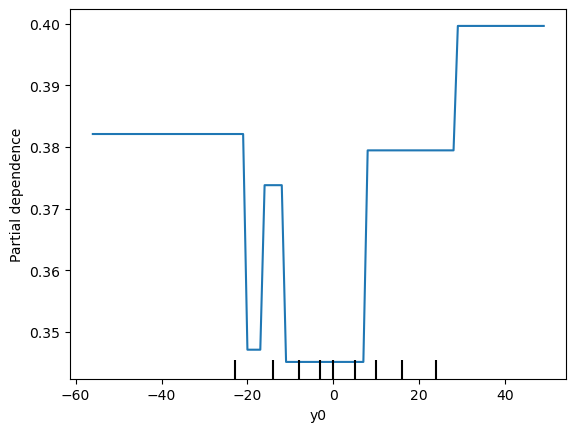

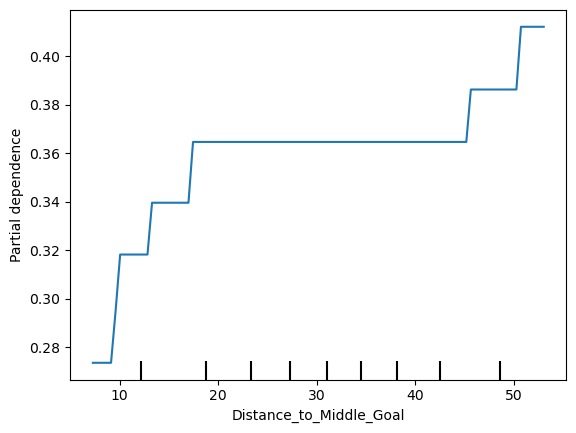

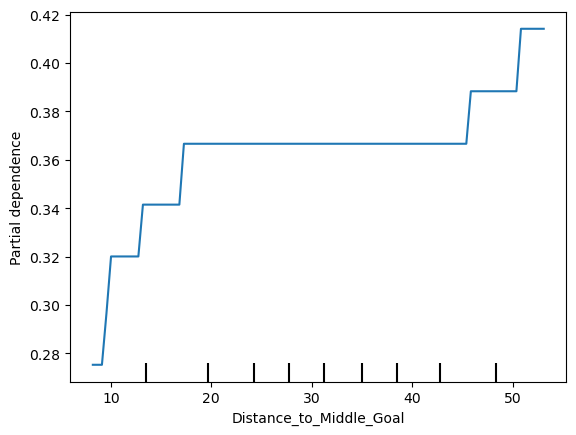

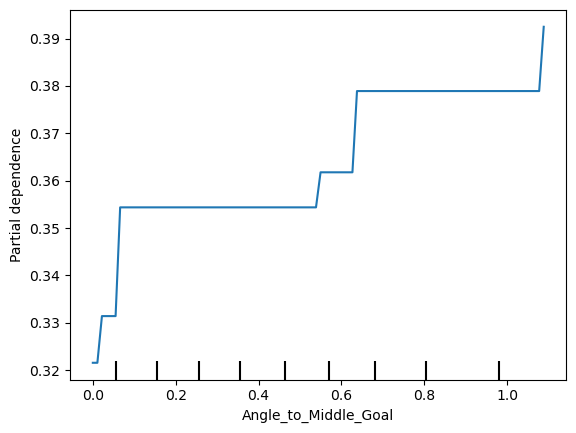

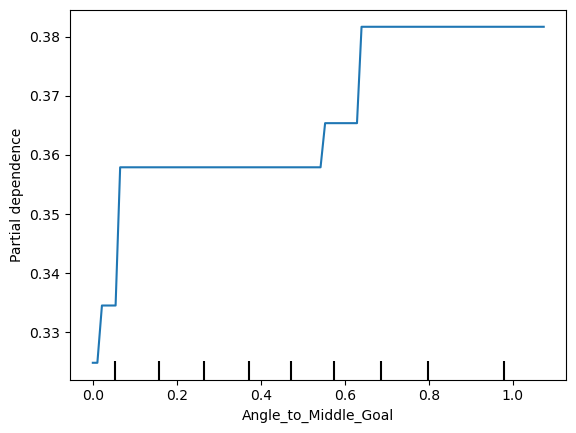

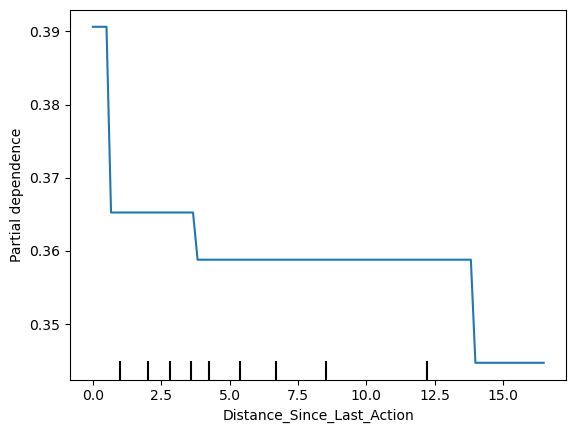

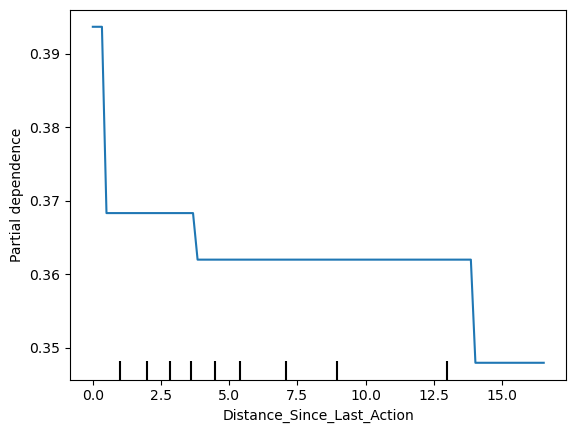

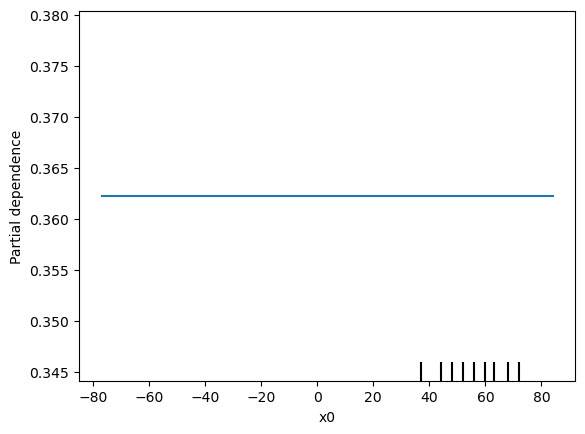

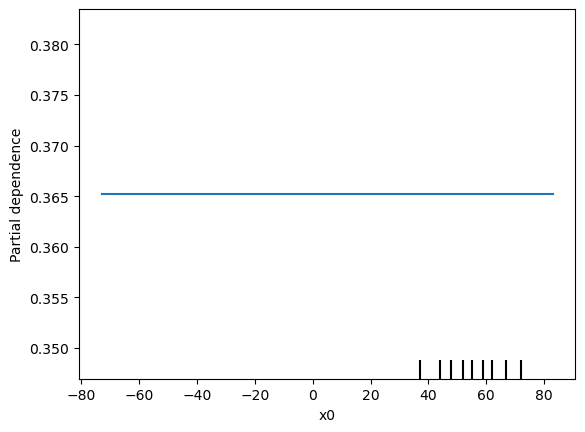

In [29]:
for col in top_10_features:
    train_xgb_evals.plot_pdp([col])
    test_xgb_evals.plot_pdp([col])

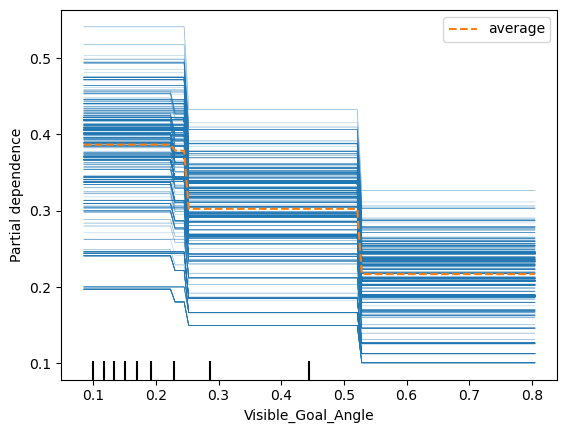

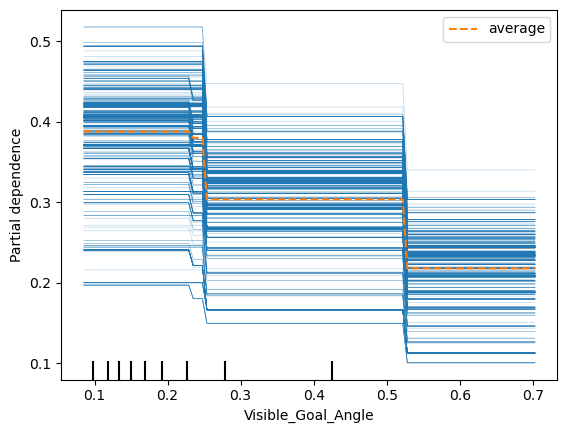

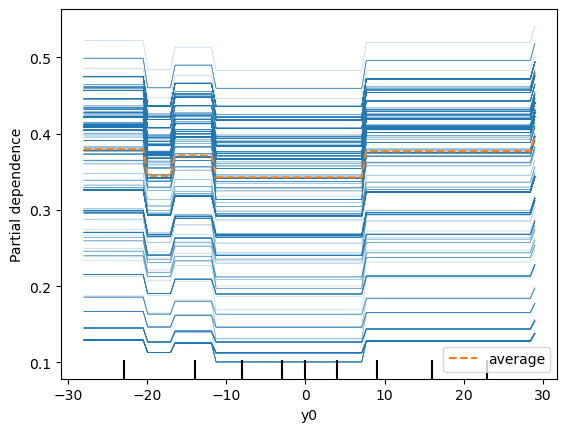

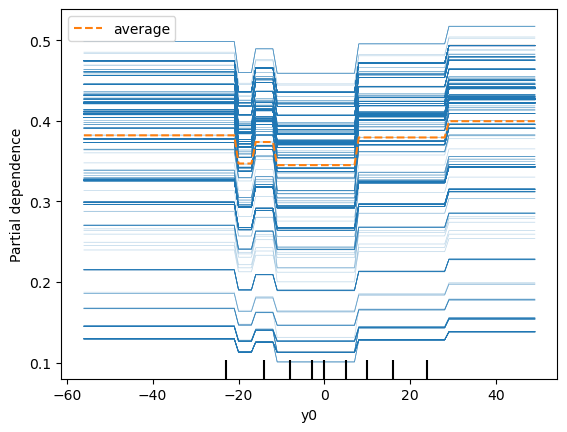

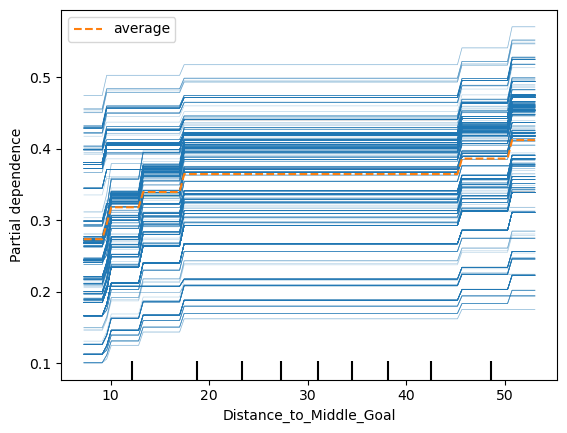

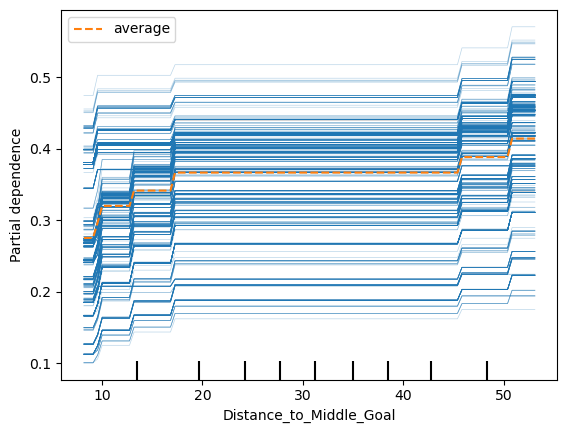

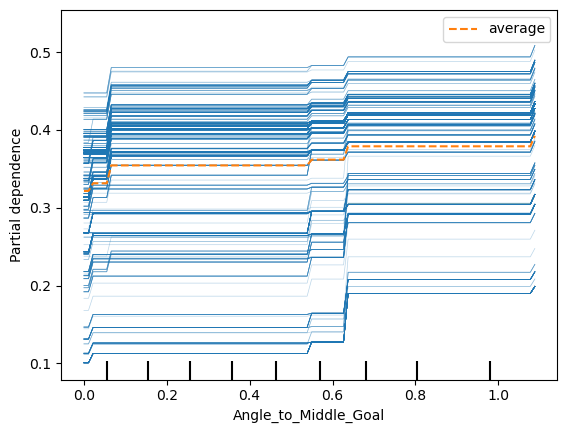

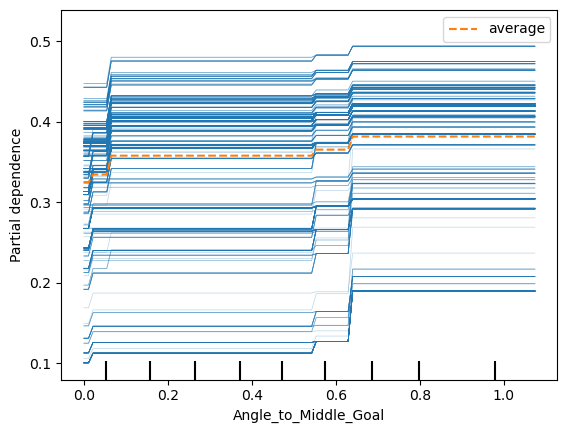

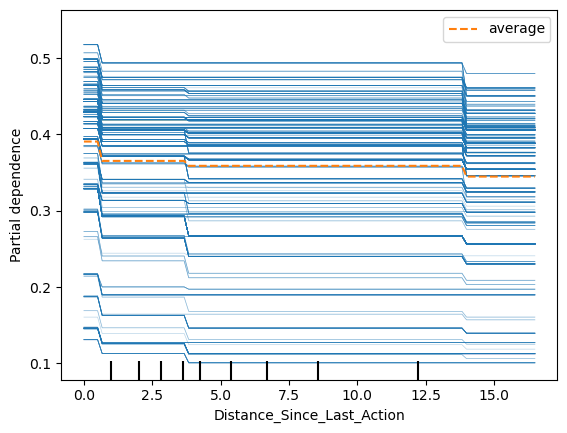

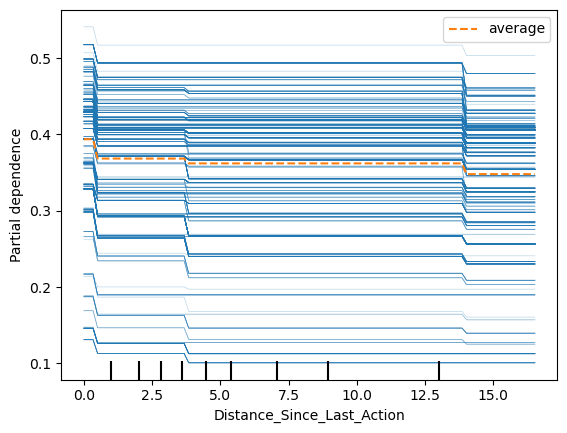

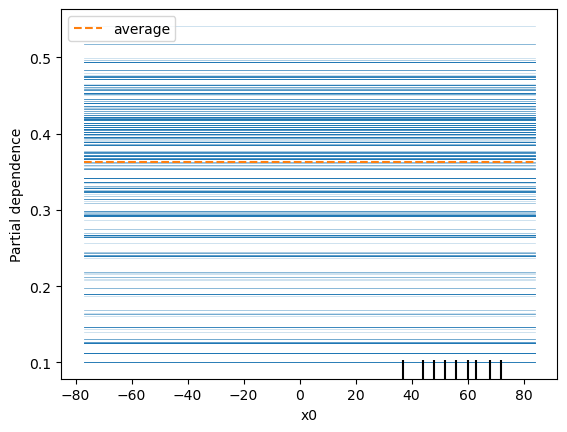

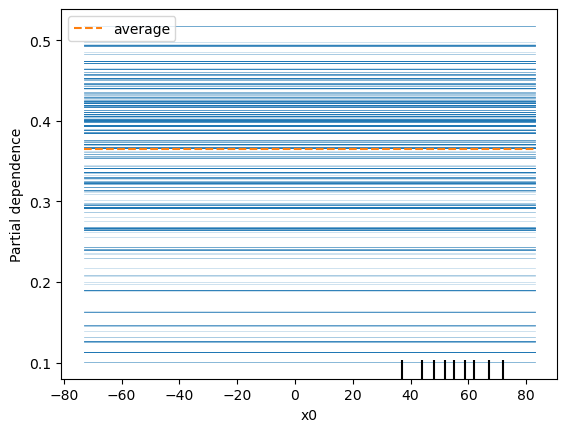

In [30]:
for col in top_10_features:
    train_xgb_evals.plot_ice([col])
    test_xgb_evals.plot_ice([col])

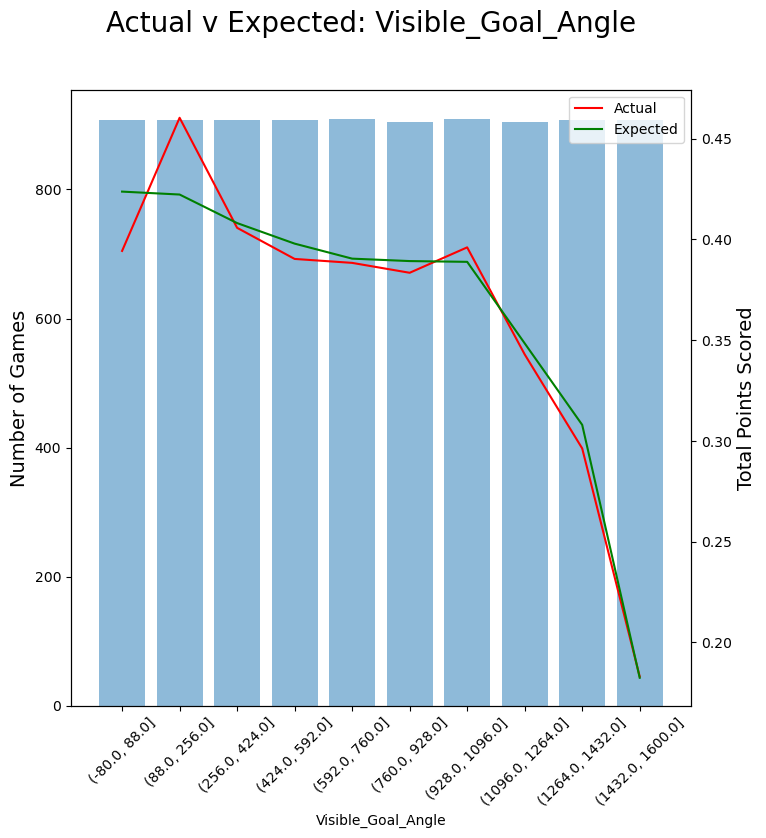

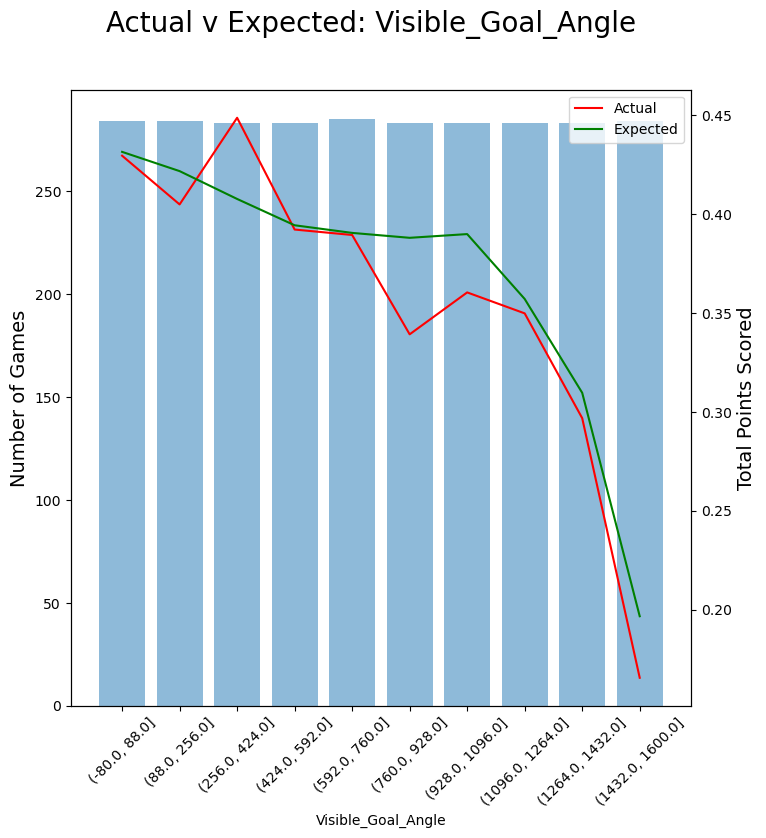

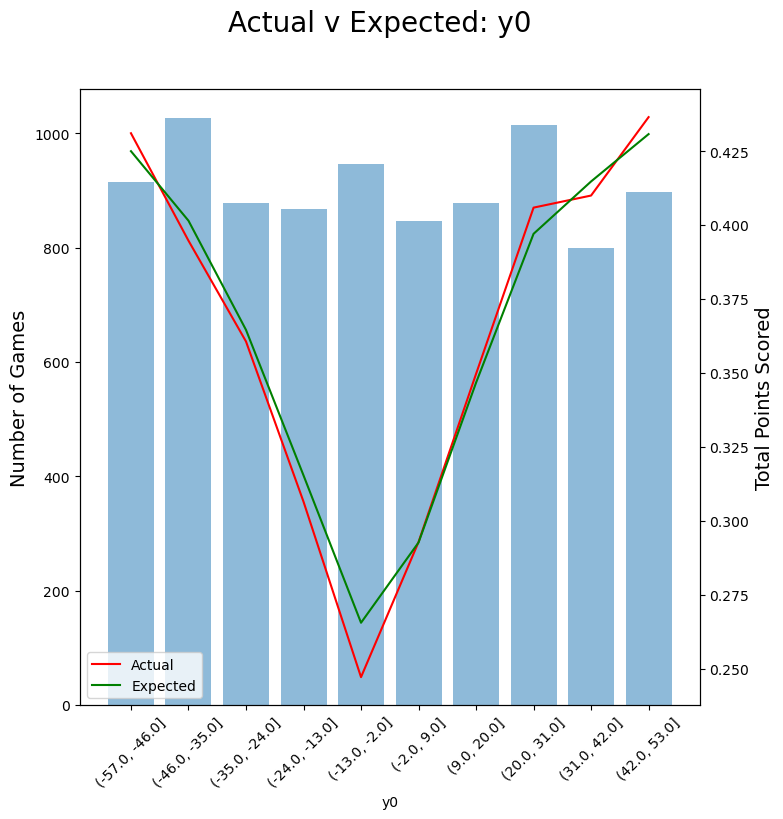

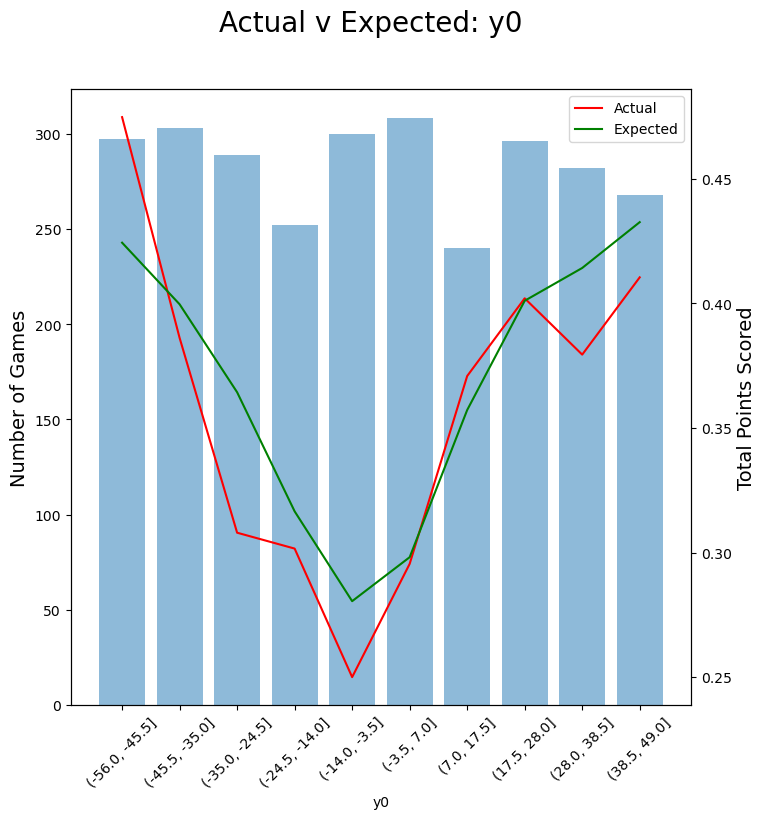

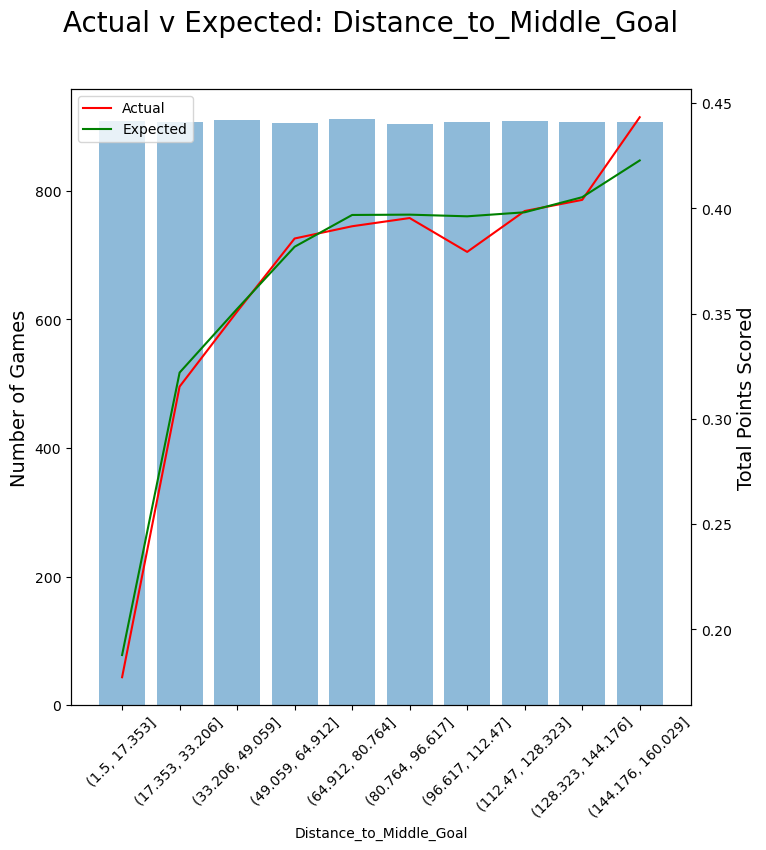

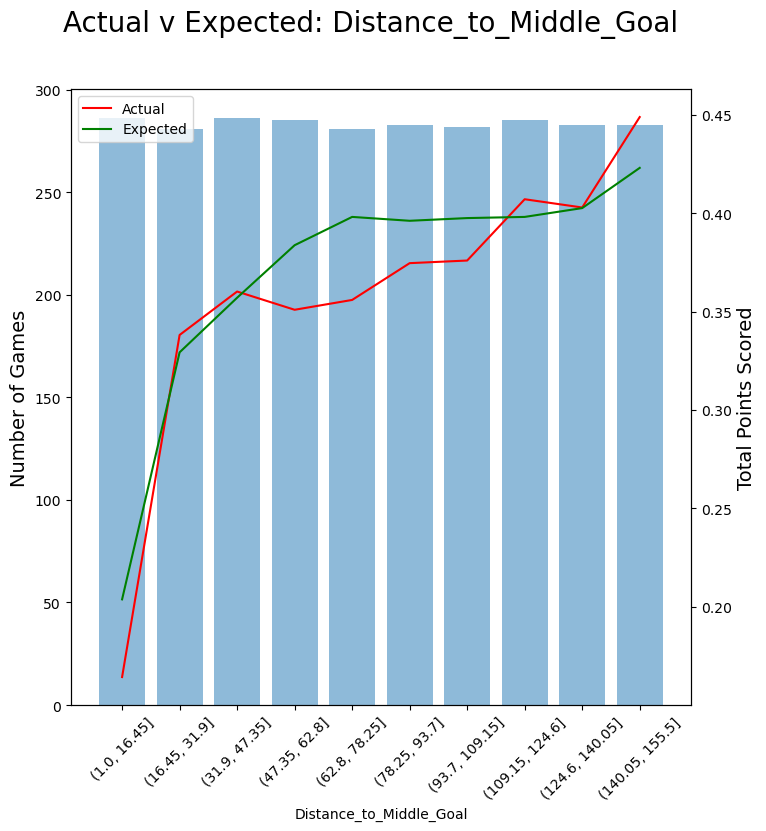

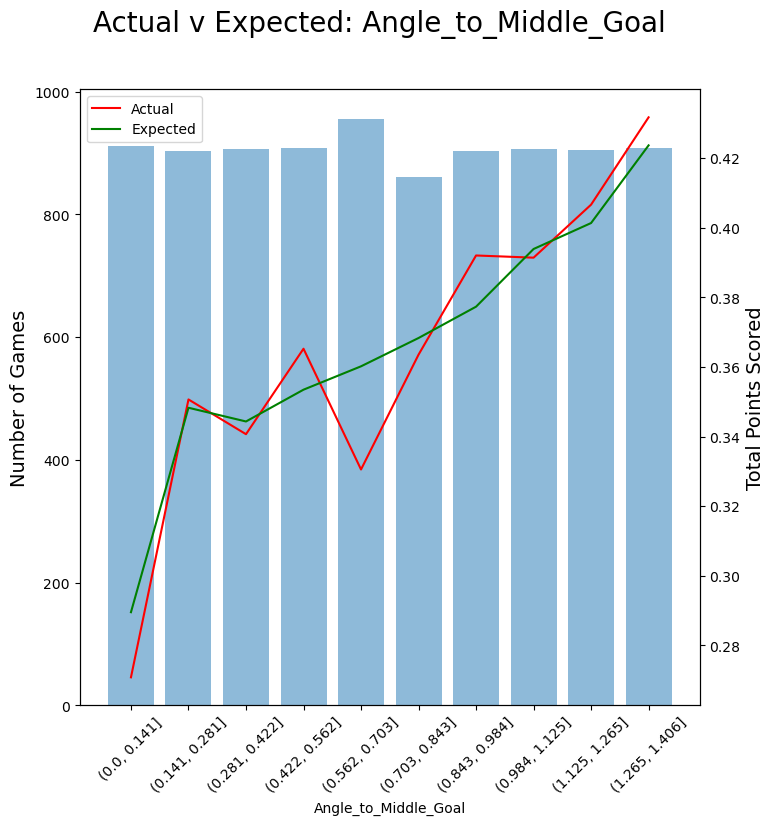

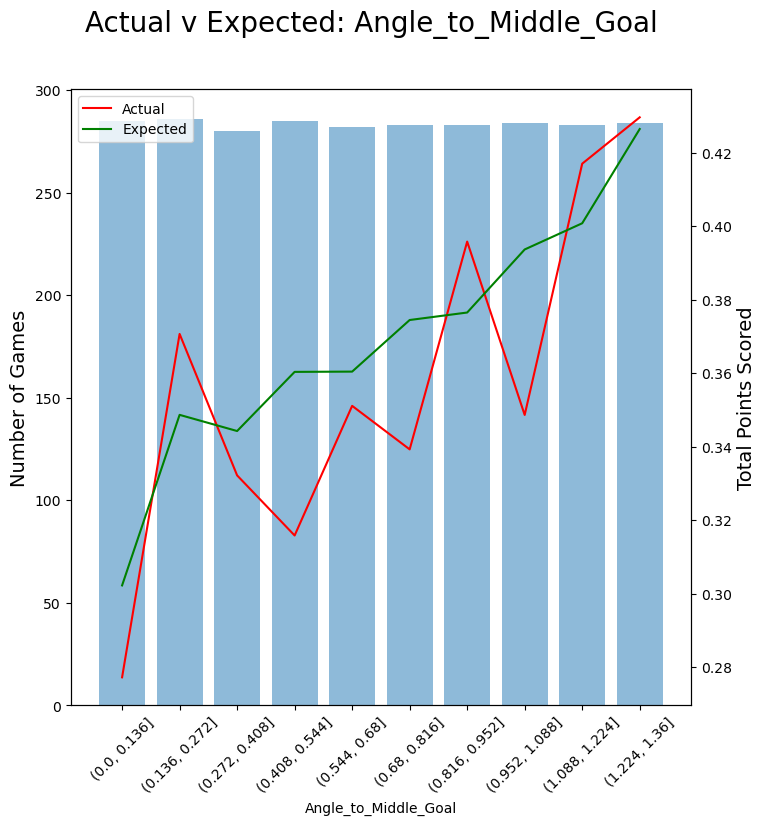

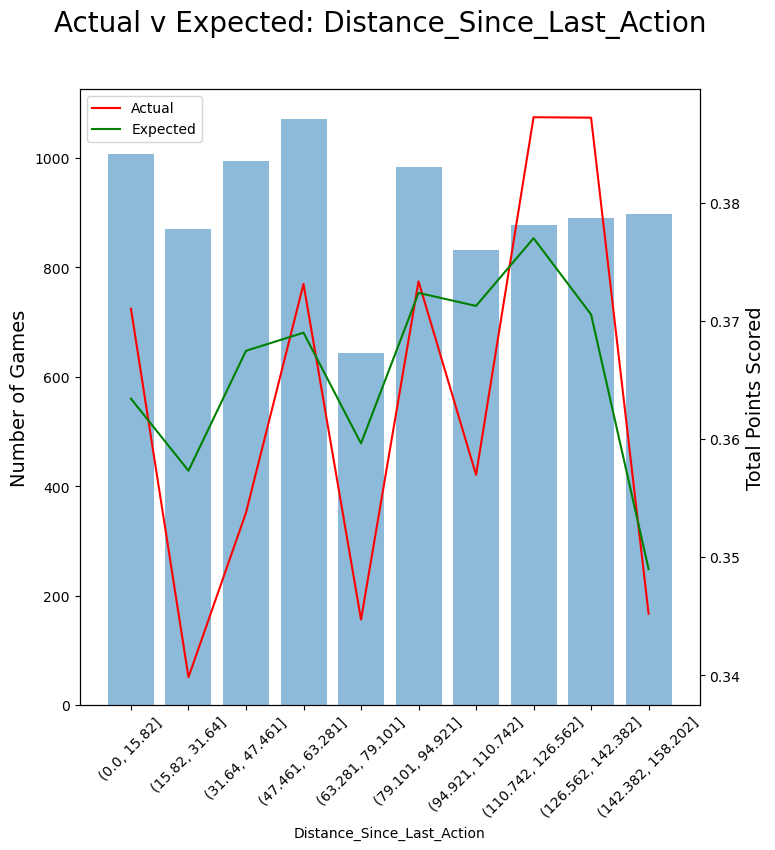

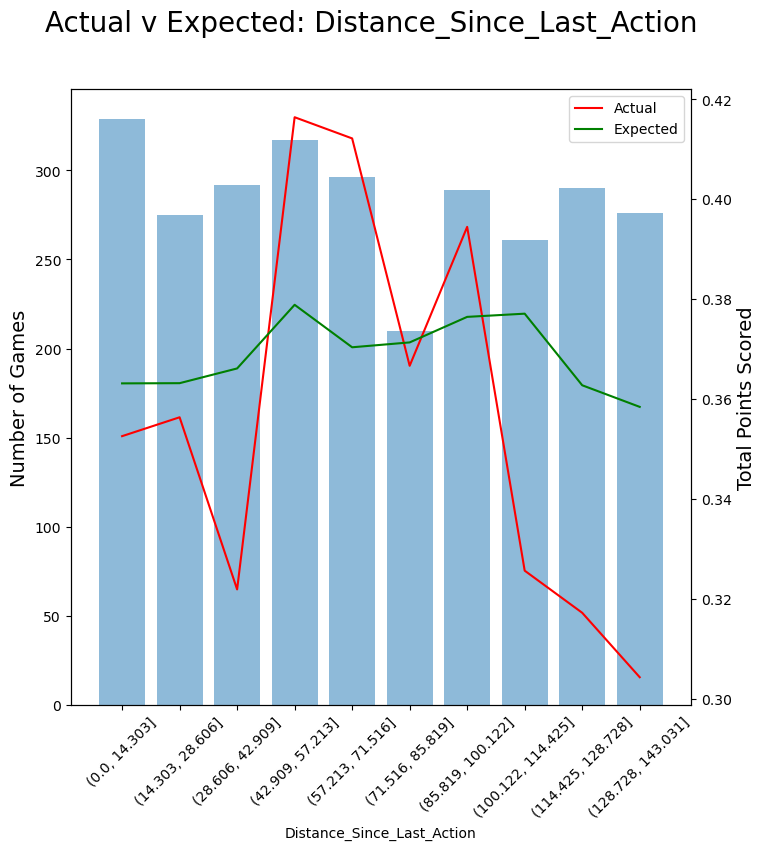

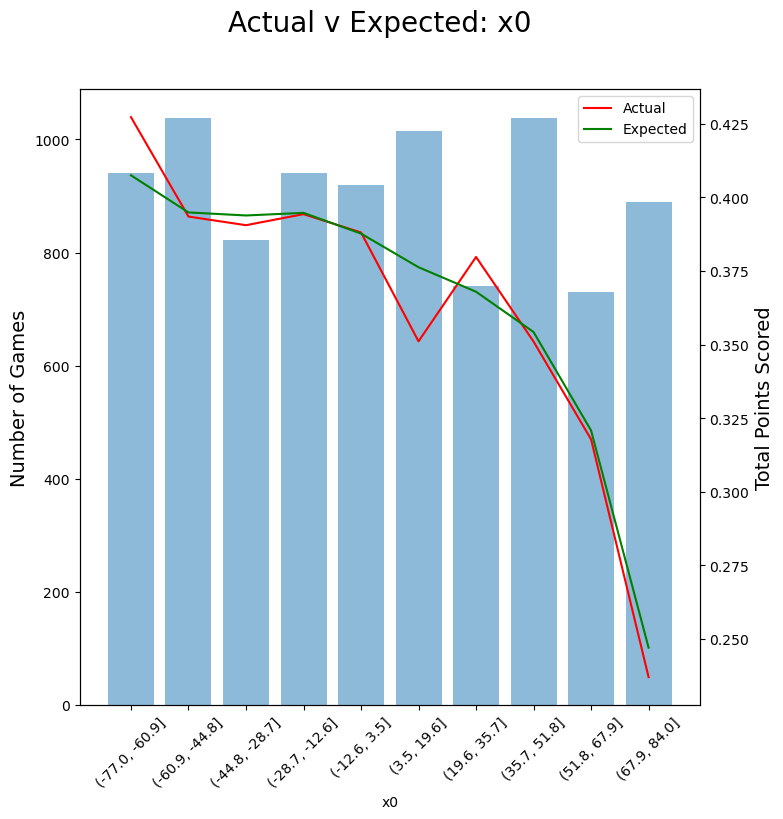

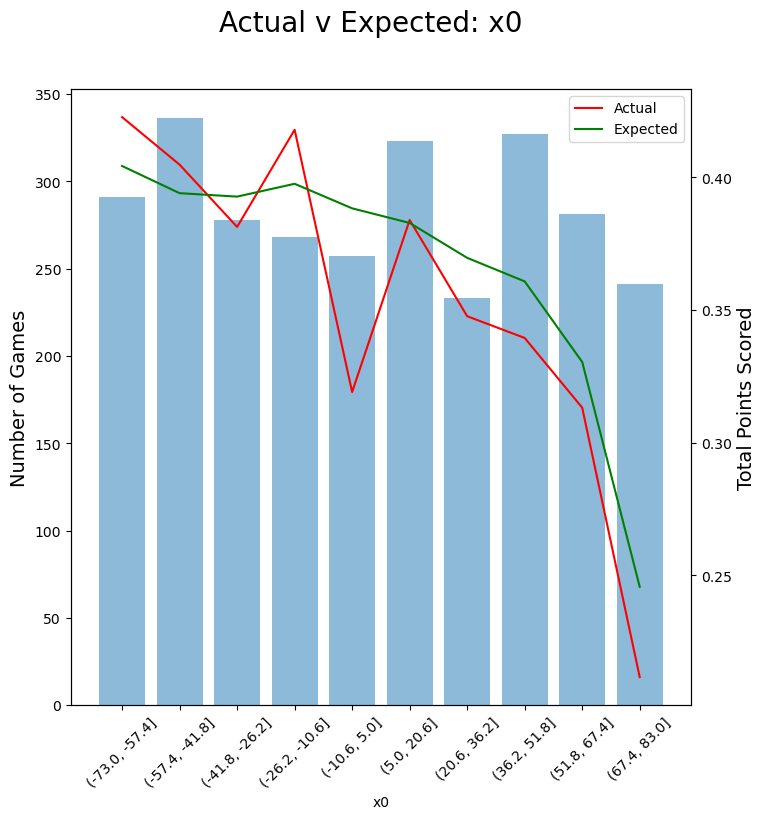

In [31]:
for col in top_10_features:
    train_xgb_evals.plot_feature_ave(col)
    test_xgb_evals.plot_feature_ave(col)

Model Metrics (for probabilities, mainly want calibration curve, logloss and brier score loss)

In [32]:
train_xgb_evals.get_log_loss(), test_xgb_evals.get_log_loss()

Expected Log-Loss: 	0.6375
Expected Log-Loss: 	0.6356


(0.6374527961421722, 0.635559148771251)

In [33]:
train_xgb_evals.get_brier_score_loss(), test_xgb_evals.get_brier_score_loss()

Expected Brier Score: 	0.2238
Expected Brier Score: 	0.2231


(0.2238401693398705, 0.2230546769466137)

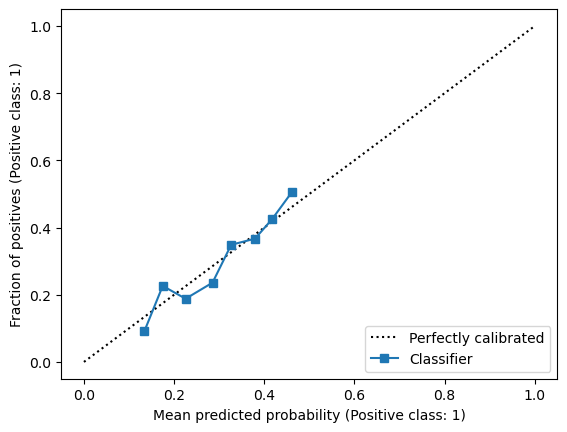

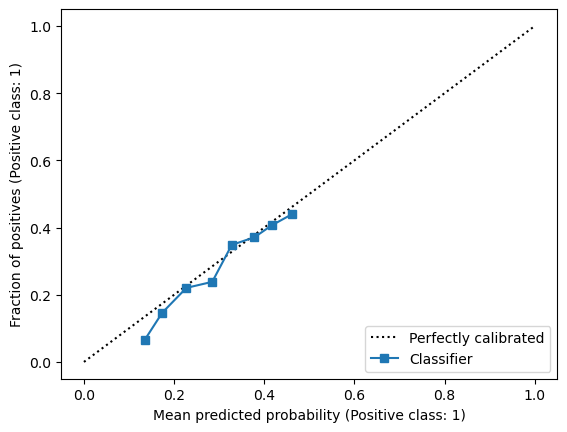

In [36]:
train_xgb_evals.display_calibration_curve(nbins=20)
test_xgb_evals.display_calibration_curve(nbins=20)